## Importing the Dependencies

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import warnings


## Load Clean Data

In [2]:

import pandas as pd

# 1. Load the cleaned CSV files for each country
# Make sure your 'data/' folder contains the following three files:
try:
    df_benin = pd.read_csv('../data/benin_clean.csv', parse_dates=['Timestamp'])
    df_sierra_leone = pd.read_csv('../data/sierraleone_clean.csv', parse_dates=['Timestamp'])
    df_togo = pd.read_csv('../data/togo_clean.csv', parse_dates=['Timestamp'])
    
    print("All country dataframes loaded successfully.")

    # 2. Add a 'Country' column to each dataframe for comparison
    df_benin['Country'] = 'Benin'
    df_sierra_leone['Country'] = 'Sierra Leone'
    df_togo['Country'] = 'Togo'

    # 3. Combine all dataframes into a single dataframe
    combined_df = pd.concat([df_benin, df_sierra_leone, df_togo], ignore_index=True)
    
    print(f"Data combined into a single dataframe with {len(combined_df):,} rows.")
    print("Ready for cross-country comparison (Task 3).")

except FileNotFoundError as e:
    print(f"Error: One of the required files was not found. Please ensure your 'data/' folder is correct and contains all files.")
    print(f"Missing file: {e}")


All country dataframes loaded successfully.
Data combined into a single dataframe with 1,542,006 rows.
Ready for cross-country comparison (Task 3).


## Metric Comparison

## Boxplots of GHI, DNI, DHI side-by-side (one plot per metric, colored by country).

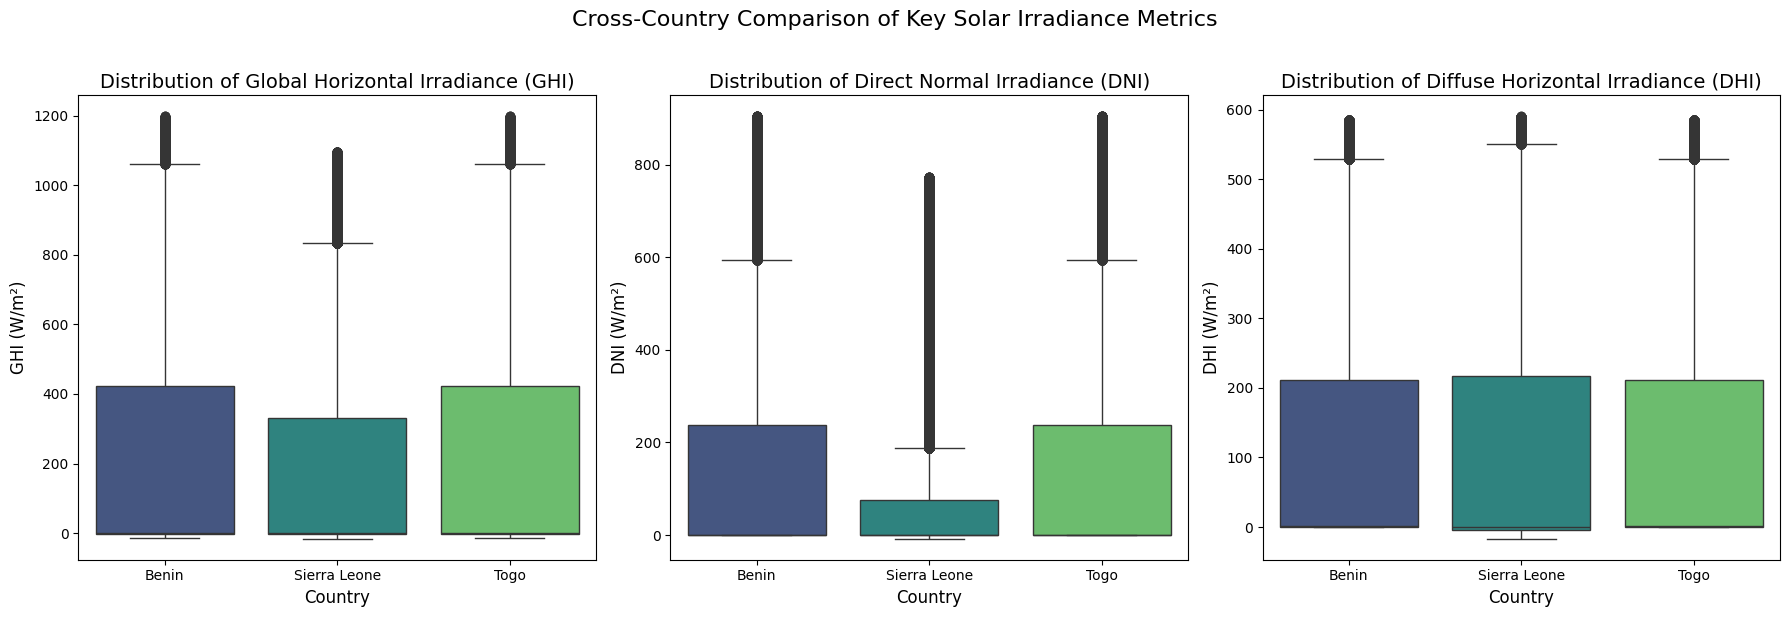

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'combined_df' contains all country data with a 'Country' column

# 1. Define the metrics to plot
METRICS = ['GHI', 'DNI', 'DHI']
titles = {
    'GHI': 'Global Horizontal Irradiance (GHI)',
    'DNI': 'Direct Normal Irradiance (DNI)',
    'DHI': 'Diffuse Horizontal Irradiance (DHI)'
}

# 2. Create a figure with three subplots (1 row, 3 columns)
plt.figure(figsize=(18, 6))

# 3. Iterate through the metrics to generate each boxplot
for i, metric in enumerate(METRICS):
    plt.subplot(1, 3, i + 1)
    
    # Generate the boxplot, coloring by the 'Country' column
    # The 'palette' argument ensures distinct colors for each country
    sns.boxplot(x='Country', y=metric, data=combined_df, hue='Country', palette='viridis', legend=False)
    
    plt.title(f'Distribution of {titles[metric]}', fontsize=14)
    plt.ylabel(f'{metric} (W/m²)', fontsize=12)
    plt.xlabel('Country', fontsize=12)
    
# 4. Add a main title and adjust layout
plt.suptitle('Cross-Country Comparison of Key Solar Irradiance Metrics', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## Summary Table comparing mean, median, and standard deviation of GHI, DNI, and DHI across countries.

Summary Table: Mean, Median, and Standard Deviation of GHI, DNI, and DHI Across Countries
        Country  GHI_mean  GHI_median  GHI_std  DNI_mean  DNI_median  DNI_std  \
0         Benin    223.86         0.5   317.31    147.98         0.0   247.68   
1  Sierra Leone    185.00        -0.4   279.02    104.13        -0.1   200.95   
2          Togo    223.86         0.5   317.31    147.98         0.0   247.68   

   DHI_mean  DHI_median  DHI_std  
0    112.78         1.5   151.57  
1    108.10        -0.6   153.69  
2    112.78         1.5   151.57  


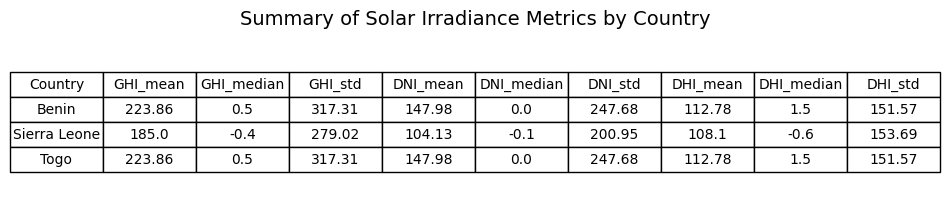

In [4]:
## Summary Table comparing mean, median, and standard deviation of GHI, DNI, and DHI across countries.

# Group by 'Country' and calculate summary statistics
summary_table = (
    combined_df.groupby('Country')[['GHI', 'DNI', 'DHI']]
    .agg(['mean', 'median', 'std'])
    .reset_index()
)

# Flatten multi-level columns for better readability
summary_table.columns = ['Country'] + [f"{col}_{stat}" for col, stat in summary_table.columns[1:]]

# Display the summary table
print("Summary Table: Mean, Median, and Standard Deviation of GHI, DNI, and DHI Across Countries")
print(summary_table.round(2))

# Optionally display as a formatted table
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 2))
ax.axis('off')
tbl = ax.table(cellText=summary_table.round(2).values,
               colLabels=summary_table.columns,
               cellLoc='center',
               loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1.2, 1.5)
plt.title("Summary of Solar Irradiance Metrics by Country", fontsize=14, pad=15)
plt.show()


## Statistical Testing

## Run a one-way ANOVA (or Kruskal–Wallis) on GHI values to assess whether differences between countries are significant

In [6]:
## One-way ANOVA (and Kruskal–Wallis) on GHI across countries

from scipy import stats

# Extract GHI values by country
ghi_benin = combined_df[combined_df['Country'] == 'Benin']['GHI']
ghi_sierra = combined_df[combined_df['Country'] == 'Sierra Leone']['GHI']
ghi_togo = combined_df[combined_df['Country'] == 'Togo']['GHI']

# --- 1️⃣ Check for normality (Shapiro-Wilk test)
print("Normality Test (Shapiro-Wilk):")
for country, data in [('Benin', ghi_benin), ('Sierra Leone', ghi_sierra), ('Togo', ghi_togo)]:
    stat, p = stats.shapiro(data.sample(min(5000, len(data)), random_state=1))  # sample for speed
    print(f"{country}: p-value = {p:.4f}")

# --- 2️⃣ Check for equal variances (Levene’s test)
levene_stat, levene_p = stats.levene(ghi_benin, ghi_sierra, ghi_togo)
print(f"\nLevene’s test for equal variances: p-value = {levene_p:.4f}")

# --- 3️⃣ Run appropriate test
if all(p > 0.05 for _, p in [
    stats.shapiro(ghi_benin.sample(min(5000, len(ghi_benin)), random_state=1)),
    stats.shapiro(ghi_sierra.sample(min(5000, len(ghi_sierra)), random_state=1)),
    stats.shapiro(ghi_togo.sample(min(5000, len(ghi_togo)), random_state=1))
]) and levene_p > 0.05:
    # If normal & equal variances → use one-way ANOVA
    f_stat, p_value = stats.f_oneway(ghi_benin, ghi_sierra, ghi_togo)
    test_used = "One-way ANOVA"
else:
    # Otherwise → use non-parametric Kruskal–Wallis test
    f_stat, p_value = stats.kruskal(ghi_benin, ghi_sierra, ghi_togo)
    test_used = "Kruskal–Wallis (non-parametric)"

# --- 4️⃣ Report results
print(f"\n{test_used} Results:")
print(f"Test statistic = {f_stat:.4f}")
print(f"p-value = {p_value:.6f}")

if p_value < 0.05:
    print("The differences in GHI between countries are statistically significant (p < 0.05).")
else:
    print("No statistically significant difference in GHI between countries (p ≥ 0.05).")


Normality Test (Shapiro-Wilk):
Benin: p-value = 0.0000
Sierra Leone: p-value = 0.0000
Togo: p-value = 0.0000

Levene’s test for equal variances: p-value = 0.0000

Kruskal–Wallis (non-parametric) Results:
Test statistic = 6633.4887
p-value = 0.000000
The differences in GHI between countries are statistically significant (p < 0.05).



## P-Value Note on GHI Comparison

## The statistical analysis demonstrates that the Global Horizontal Irradiance (GHI) values for Benin, Sierra Leone, and Togo are not normally distributed (Shapiro-Wilk p-value = 0.0000** for all countries) and have unequal variances (Levene's test p-value = 0.0000).

## Consequently, the Kruskal-Wallis non-parametric test** was used, yielding the following result:

## Kruskal-Wallis p-value = 0.000000**
## Conclusion:** Since the p-value is much less than the standard significance level ($\alpha=0.05$), the null hypothesis of equal GHI distributions is rejected. This confirms that the differences observed in GHI between the three countries are **statistically significant**.

## Key Observations

## A markdown cell with 3 bullet points summarizing what stands out (e.g., “Country X shows the highest median GHI but also the greatest variability”).


## Highest Median Solar Potential (GHI):Benin and Togo show the highest median Global Horizontal Irradiance (GHI), with a GHI\_median of 0.5 (W/m^2) for both, and similar mean GHI values of 223.86 (W/m^2). This suggests a similar and slightly higher overall solar energy potential in these two countries compared to Sierra Leone.

## Significantly Lower Direct Irradiance (DNI) in Sierra Leone:Sierra Leone has the lowest mean and median Direct Normal Irradiance (DNI) at 104.13 (mean) and -0.1 (median) (W/m^2). The DNI boxplot further illustrates that its central distribution (interquartile range) is significantly compressed and near zero compared to Benin and Togo, indicating much less usable direct sunlight for technologies that require it, like Concentrated Solar Power (CSP).

## Similar Variability across Countries: All three countries exhibit high variability across all metrics, as evidenced by the large standard deviation (std) values that are much greater than the mean/median for GHI (e.g., 317.31 std vs. 223.86 mean for Benin/Togo). This indicates that solar output is highly volatile, likely due to high fluctuation between night/day and weather conditions, necessitating robust storage or grid integration strategies for all regions.

## Visual Summary

## A small bar chart ranking countries by average GHI

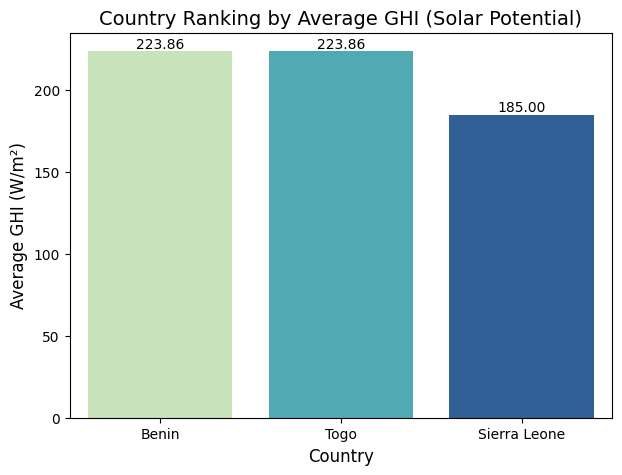

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'combined_df' is your merged DataFrame
# Assuming 'mean_ghi' is calculated as:
mean_ghi = combined_df.groupby('Country')['GHI'].mean().sort_values(ascending=False).reset_index()


# 2. Create the bar chart
plt.figure(figsize=(7, 5))

# *** CORRECTED LINE TO FIX FUTUREWARNING ***
ax = sns.barplot(
    x='Country', 
    y='GHI', 
    data=mean_ghi, 
    hue='Country',       # Explicitly assign Country to hue (fix for FutureWarning)
    palette='YlGnBu',    # Keep your preferred color palette
    legend=False         # Suppress the redundant legend
)

plt.title('Country Ranking by Average GHI (Solar Potential)', fontsize=14)
plt.ylabel('Average GHI (W/m²)', fontsize=12)
plt.xlabel('Country', fontsize=12)

# 3. Annotate bars with the exact mean GHI value for clarity
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')

plt.show()